In [1]:
# 나눔고딕 폰트 설치 및 설정
!apt-get update -qq
!apt-get install fonts-nanum -qq
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped dire

In [1]:
# 1. 데이터 로드 및 전처리 (MLP와 동일)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

# 폰트 설정
import matplotlib.font_manager as fm
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=10)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False


In [14]:


url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)

cols = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
target_col = 'Survived'
df = df[cols + [target_col]]

# 결측치 처리
for col in ['Fare']:
    df[col] = df[col].fillna(df[col].mean())
for col in ['Sex', 'Embarked']:
    df[col] = df[col].fillna(df[col].mode()[0])
    
df['Age'] = df.groupby(['Pclass','Sex'])['Age'].transform(lambda x:
  x.fillna(x.median()))

# 범주형 인코딩
df['Sex'] = LabelEncoder().fit_transform(df['Sex'])
df['Embarked'] = LabelEncoder().fit_transform(df['Embarked'])

print(df.head())

# 입력/정규화
X = df[cols].values.astype(np.float32)
y = df[target_col].values.astype(np.int64)
scaler = StandardScaler()
# Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  Survived
num_idx = [0,2,3,4,5]
X[:,num_idx] = scaler.fit_transform(X[:,num_idx])
print(df.head())
# --- 핵심: RNN 입력을 (샘플수, 시퀀스길이, 1) 형태로 변경 ---
# (각 승객: 7개 feature → 7단계 시퀀스, 각 단계는 scalar 1개)
X_rnn = X.reshape(X.shape[0], X.shape[1], 1)
print(X_rnn.shape)
X_train, X_test, y_train, y_test = train_test_split(X_rnn, y, test_size=0.2, random_state=42)


   Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  Survived
0       3    1  22.0      1      0   7.2500         2         0
1       1    0  38.0      1      0  71.2833         0         1
2       3    0  26.0      0      0   7.9250         2         1
3       1    0  35.0      1      0  53.1000         2         1
4       3    1  35.0      0      0   8.0500         2         0
   Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  Survived
0       3    1  22.0      1      0   7.2500         2         0
1       1    0  38.0      1      0  71.2833         0         1
2       3    0  26.0      0      0   7.9250         2         1
3       1    0  35.0      1      0  53.1000         2         1
4       3    1  35.0      0      0   8.0500         2         0
(891, 7, 1)


📊 타이타닉 데이터 분포 분석
데이터 크기: (891, 8)
결측치 현황:
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Survived    0
dtype: int64

🎯 생존률 분포 (클래스 불균형 확인)
사망: 549명 (61.6%)
생존: 342명 (38.4%)

📈 Age 통계:
  평균: 29.11
  중앙값: 26.00
  표준편차: 13.30
  왜도: 0.53
  첨도: 0.72
  이상치 개수: 33개

📈 Fare 통계:
  평균: 32.20
  중앙값: 14.45
  표준편차: 49.69
  왜도: 4.79
  첨도: 33.40
  이상치 개수: 116개

📈 SibSp 통계:
  평균: 0.52
  중앙값: 0.00
  표준편차: 1.10
  왜도: 3.70
  첨도: 17.88
  이상치 개수: 46개

📈 Parch 통계:
  평균: 0.38
  중앙값: 0.00
  표준편차: 0.81
  왜도: 2.75
  첨도: 9.78
  이상치 개수: 213개



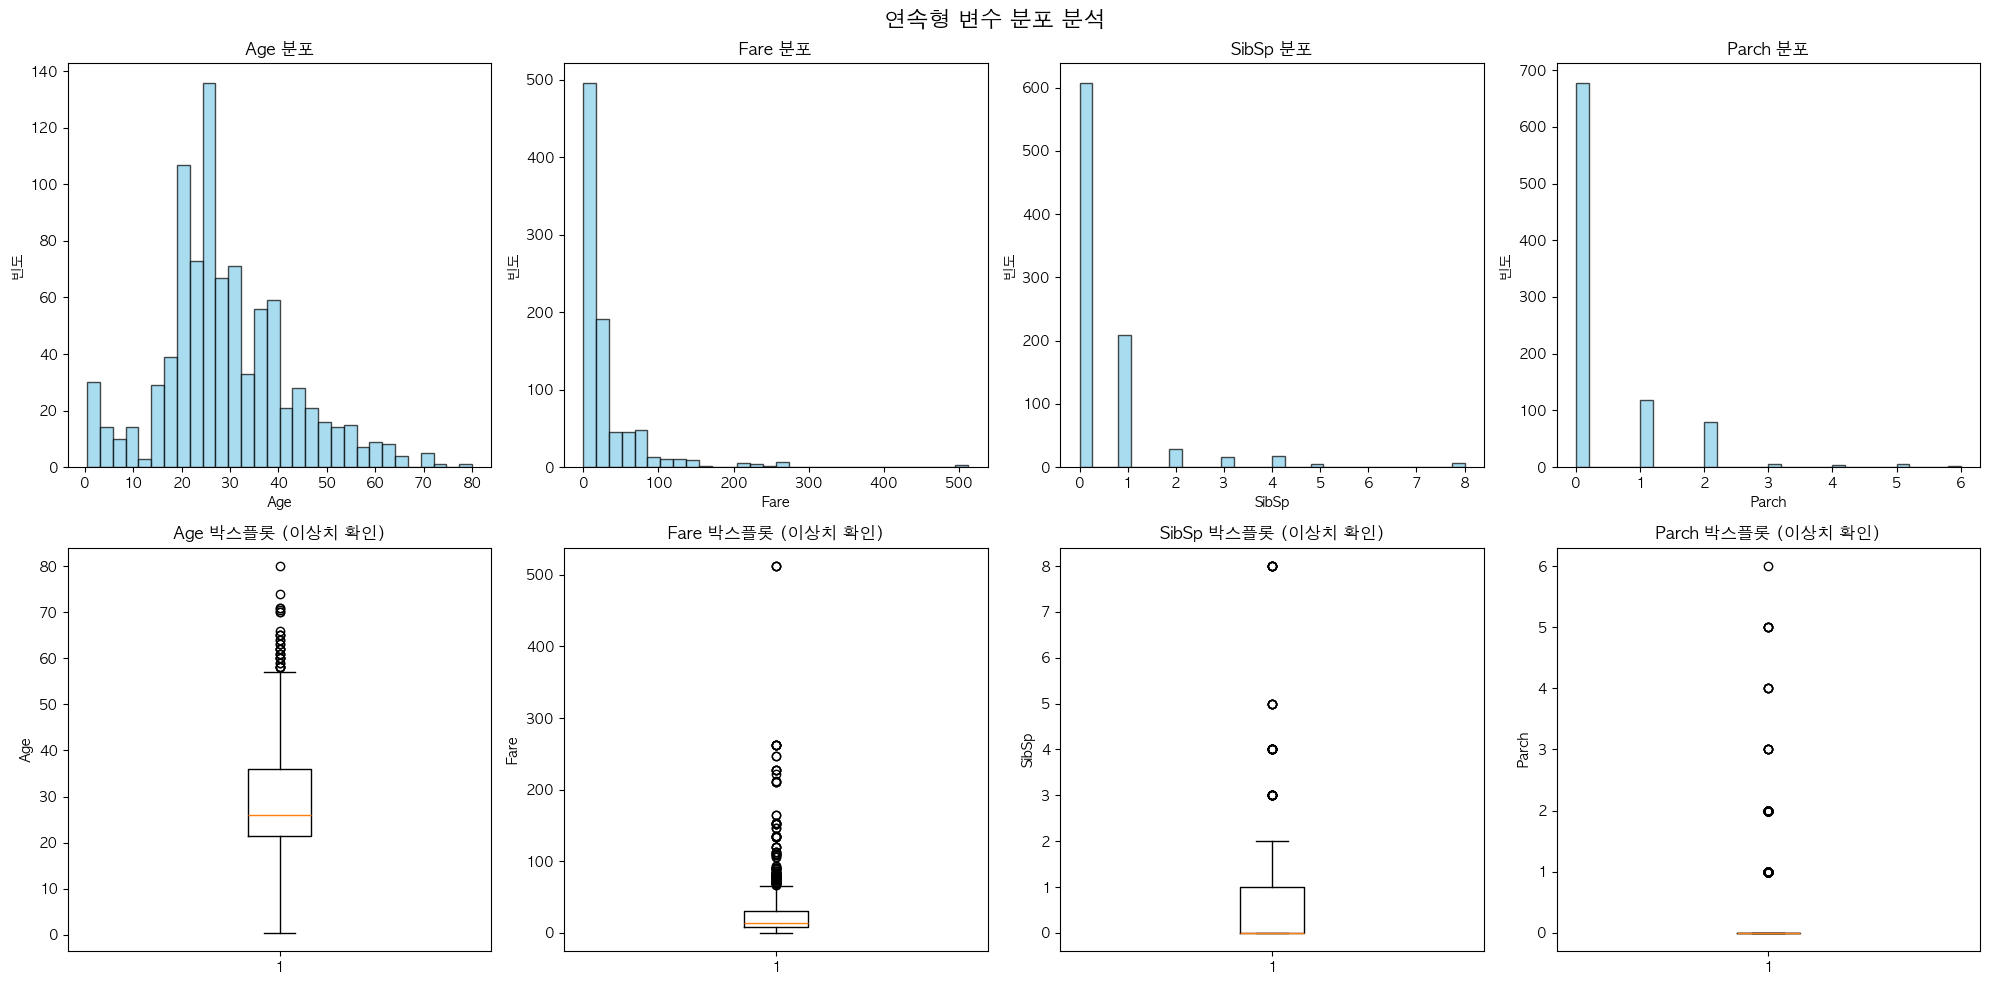

📊 Pclass 분포:
Pclass
3    491
1    216
2    184
Name: count, dtype: int64
비율:
Pclass
3    0.551
1    0.242
2    0.207
Name: proportion, dtype: float64

📊 Sex 분포:
Sex
1    577
0    314
Name: count, dtype: int64
비율:
Sex
1    0.648
0    0.352
Name: proportion, dtype: float64

📊 Embarked 분포:
Embarked
2    646
0    168
1     77
Name: count, dtype: int64
비율:
Embarked
2    0.725
0    0.189
1    0.086
Name: proportion, dtype: float64



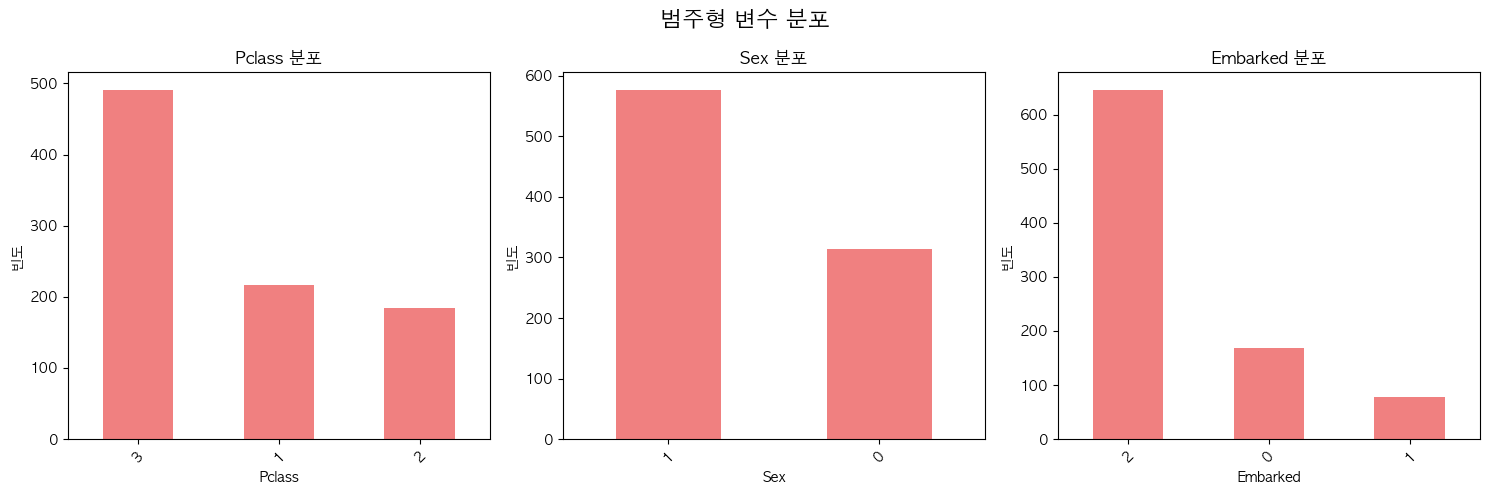

🔍 Age와 생존의 관계:
  생존자 평균:  28.11
  사망자 평균:  29.74
  t-검정 p-value:  0.0755
  유의미함: No

🔍 Fare와 생존의 관계:
  생존자 평균:  48.40
  사망자 평균:  22.12
  t-검정 p-value:  0.0000
  유의미함: Yes

🔍 SibSp와 생존의 관계:
  생존자 평균:  0.47
  사망자 평균:  0.55
  t-검정 p-value:  0.2922
  유의미함: No

🔍 Parch와 생존의 관계:
  생존자 평균:  0.46
  사망자 평균:  0.33
  t-검정 p-value:  0.0148
  유의미함: Yes

🎯 Pclass별 생존률:
        count  sum      mean  survival_rate
Pclass                                     
1         216  136  0.629630       0.629630
2         184   87  0.472826       0.472826
3         491  119  0.242363       0.242363

🎯 Sex별 생존률:
     count  sum      mean  survival_rate
Sex                                     
0      314  233  0.742038       0.742038
1      577  109  0.188908       0.188908

🎯 Embarked별 생존률:
          count  sum      mean  survival_rate
Embarked                                     
0           168   93  0.553571       0.553571
1            77   30  0.389610       0.389610
2           646  219  0.339009       0.3390

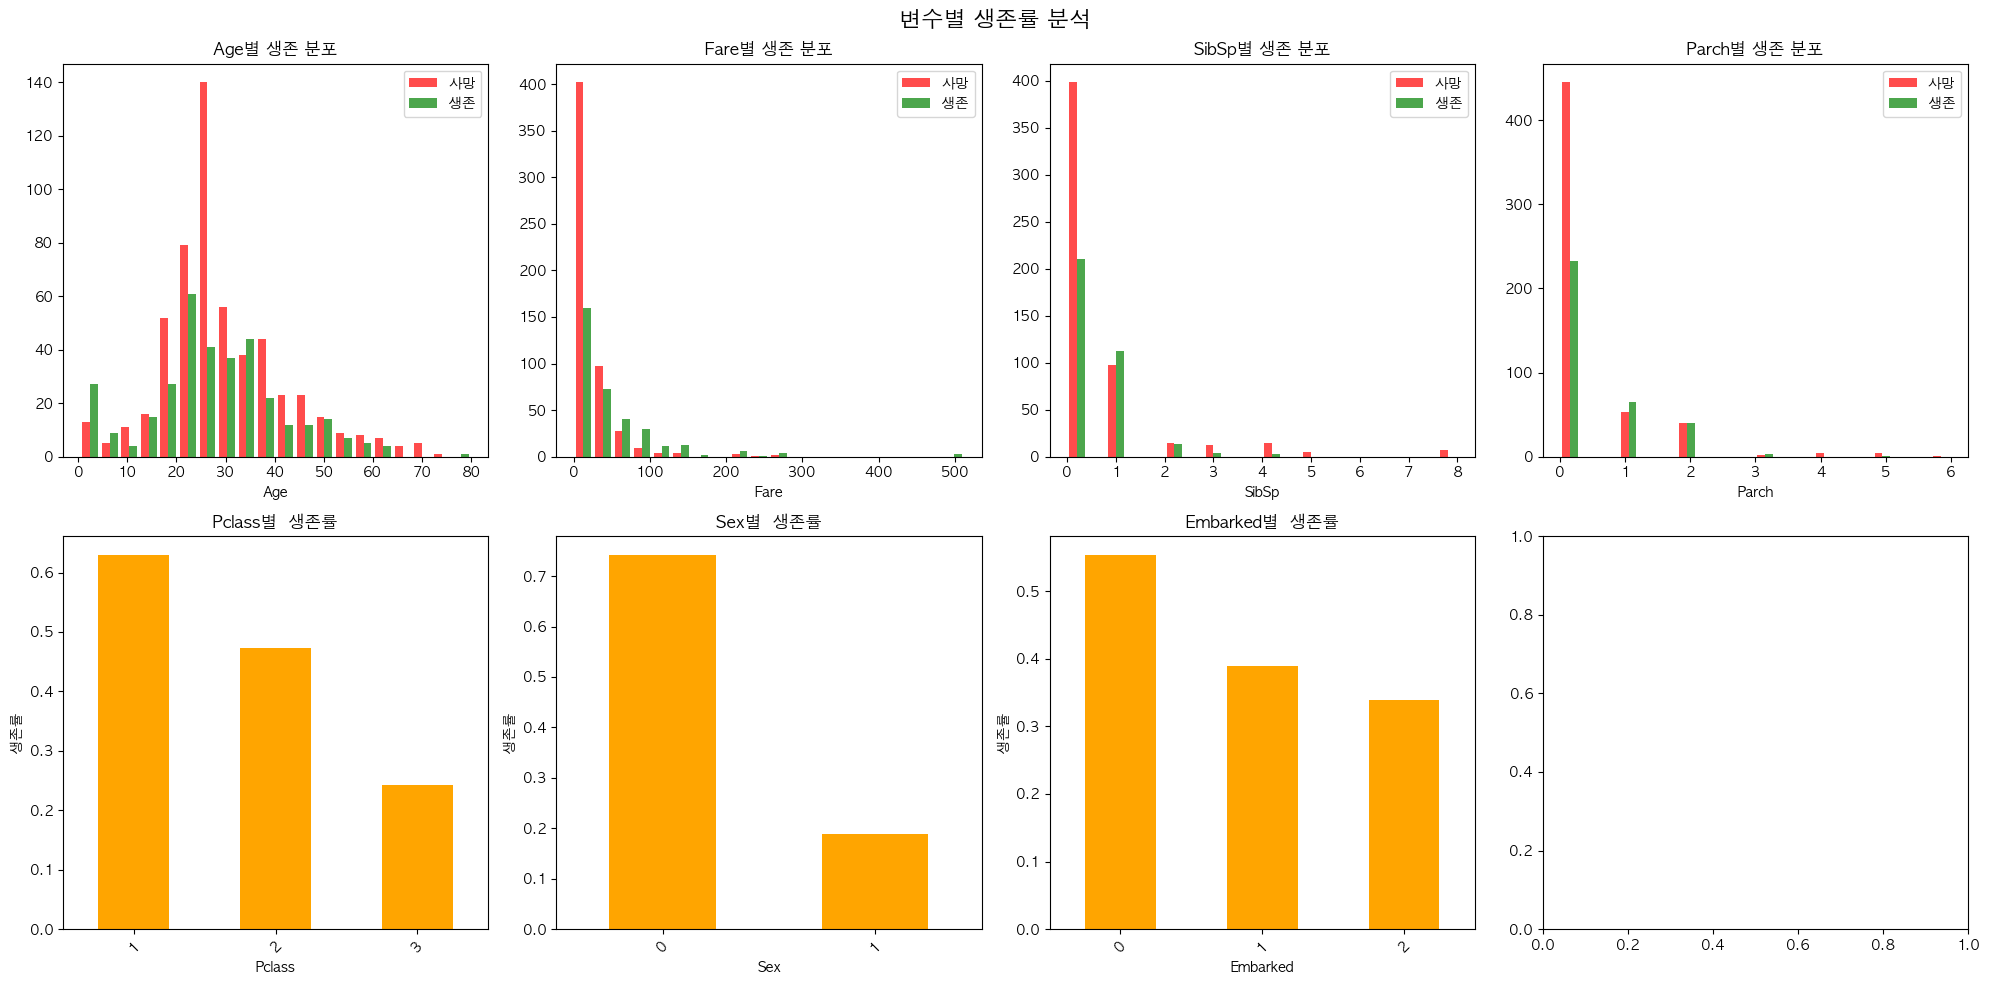

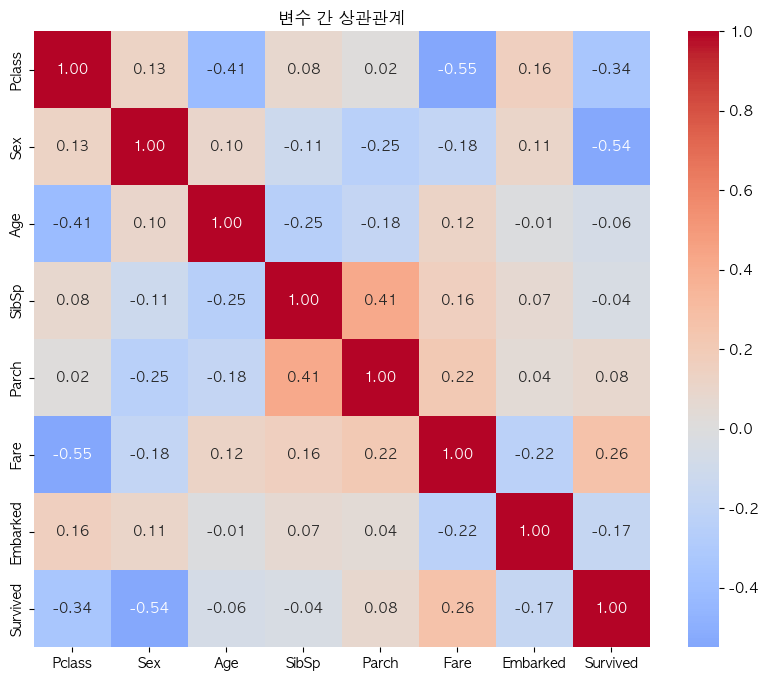

🔗 주요 상관관계:
  Sex: 0.543
  Pclass: 0.338
  Fare: 0.257
  Embarked: 0.168
  Parch: 0.082
  Age: 0.060
  SibSp: 0.035

📏 정규성 검정 (Shapiro-Wilk  test):
  Age: p-value =  0.0000, 정규분포: No
  Fare: p-value =  0.0000, 정규분포: No
  SibSp: p-value =  0.0000, 정규분포: No
  Parch: p-value =  0.0000, 정규분포: No


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,1,22.0,1,0,7.2500,2,0
1,1,0,38.0,1,0,71.2833,0,1
2,3,0,26.0,0,0,7.9250,2,1
3,1,0,35.0,1,0,53.1000,2,1
4,3,1,35.0,0,0,8.0500,2,0
...,...,...,...,...,...,...,...,...
886,2,1,27.0,0,0,13.0000,2,0
887,1,0,19.0,0,0,30.0000,2,1
888,3,0,21.5,1,2,23.4500,2,0
889,1,1,26.0,0,0,30.0000,0,1


In [11]:
# 데이터 분포 확인 코드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


font_path='/System/Library/Fonts/AppleGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=10)
plt.rcParams['font.family'] = 'AppleGothic'  # macOS
plt.rcParams['axes.unicode_minus'] = False
def analyze_data_distribution(df,  target_col='Survived'):
    print("📊 타이타닉 데이터 분포 분석")
    print("="*50)

    # 1. 기본 정보
    print(f"데이터 크기: {df.shape}")
    print(f"결측치 현황:")
    print(df.isnull().sum())
    print()

    # 2. 타겟 변수 분포 (클래스 불균형 확인)
    print("🎯 생존률 분포 (클래스 불균형 확인)")
    survival_counts = df[target_col].value_counts()
    survival_ratio = df[target_col].value_counts(normalize=True)
    print(f"사망: {survival_counts[0]}명 ({survival_ratio[0]:.1%})")
    print(f"생존: {survival_counts[1]}명 ({survival_ratio[1]:.1%})")
    print()

    # 3. 연속형 변수 분포 분석
    numeric_cols = ['Age', 'Fare', 'SibSp','Parch']

    fig, axes = plt.subplots(2, 4,figsize=(20, 10))
    fig.suptitle('연속형 변수 분포 분석',fontsize=16)

    for i, col in enumerate(numeric_cols):
        # 히스토그램
        axes[0, i].hist(df[col].dropna(),bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0, i].set_title(f'{col} 분포')
        axes[0, i].set_xlabel(col)
        axes[0, i].set_ylabel('빈도')

        # 박스플롯 (이상치 확인)
        axes[1, i].boxplot(df[col].dropna())
        axes[1, i].set_title(f'{col} 박스플롯 (이상치 확인)')
        axes[1, i].set_ylabel(col)

        # 통계 정보 출력
        print(f"📈 {col} 통계:")
        print(f"  평균: {df[col].mean():.2f}")
        print(f"  중앙값: {df[col].median():.2f}")
        print(f"  표준편차: {df[col].std():.2f}")
        print(f"  왜도: {df[col].skew():.2f}")
        print(f"  첨도: {df[col].kurtosis():.2f}")

        # 이상치 개수
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)][col]
        print(f"  이상치 개수: {len(outliers)}개")
        print()

    plt.tight_layout()
    plt.show()

    # 4. 범주형 변수 분포
    categorical_cols = ['Pclass', 'Sex','Embarked']

    fig, axes = plt.subplots(1, 3,figsize=(15, 5))
    fig.suptitle('범주형 변수 분포',fontsize=16)

    for i, col in enumerate(categorical_cols):
        df[col].value_counts().plot(kind='bar',ax=axes[i], color='lightcoral')
        axes[i].set_title(f'{col} 분포')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('빈도')
        axes[i].tick_params(axis='x',rotation=45)

        print(f"📊 {col} 분포:")
        print(df[col].value_counts())
        print(f"비율:")
        print(df[col].value_counts(normalize=True).round(3))
        print()

    plt.tight_layout()
    plt.show()

    # 5. 타겟 변수와의 관계 분석
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle('변수별 생존률 분석', fontsize=16)

    # 연속형 변수와 생존의 관계
    for i, col in enumerate(numeric_cols):
        # 생존/사망별 분포
        survived = df[df[target_col] == 1][col].dropna()
        died = df[df[target_col] == 0][col].dropna()

        axes[0, i].hist([died, survived], bins=20, alpha=0.7,
            label=['사망', '생존'],
            color=['red', 'green'])
        axes[0, i].set_title(f'{col}별 생존 분포')
        axes[0, i].set_xlabel(col)
        axes[0, i].legend()

        # 통계적 유의성 검정 (t-test)
        t_stat, p_value = stats.ttest_ind(survived, died)
        print(f"🔍 {col}와 생존의 관계:")
        print(f"  생존자 평균:  {survived.mean():.2f}")
        print(f"  사망자 평균:  {died.mean():.2f}")
        print(f"  t-검정 p-value:  {p_value:.4f}")
        print(f"  유의미함: {'Yes' if p_value   < 0.05 else 'No'}")
        print()

    # 범주형 변수와 생존의 관계
    for i, col in enumerate(categorical_cols):
          survival_by_cat = df.groupby(col)[target_col].agg(['count', 'sum', 'mean'])
          survival_by_cat['survival_rate'] = survival_by_cat['mean']

          survival_by_cat['survival_rate'].plot( kind='bar', ax=axes[1, i], color='orange')
          axes[1, i].set_title(f'{col}별  생존률')
          axes[1, i].set_xlabel(col)
          axes[1, i].set_ylabel('생존률')
          axes[1, i].tick_params(axis='x', rotation=45)

          print(f"🎯 {col}별 생존률:")
          print(survival_by_cat)
          print()

    plt.tight_layout()
    plt.show()

    # 6. 상관관계 분석
    # 숫자형 변수만 선택
    numeric_df = df.select_dtypes(include=[np.number])

    plt.figure(figsize=(10, 8))
    correlation_matrix = numeric_df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.2f')
    plt.title('변수 간 상관관계')
    plt.show()

    print("🔗 주요 상관관계:")
    # 타겟과의 상관관계가 높은 순으로 정렬
    target_corr = correlation_matrix[target_col].abs().sort_values(ascending=False)
    for var, corr in target_corr.items():
        if var != target_col:
            print(f"  {var}: {corr:.3f}")
    print()

    # 7. 정규성 검정
    print("📏 정규성 검정 (Shapiro-Wilk  test):")
    for col in numeric_cols:
        if df[col].notna().sum() > 3:  # 최소  샘플 수 확인
            sample = df[col].dropna().sample(min(5000, len(df[col].dropna())))  # 샘플링
            stat, p_value = stats.shapiro(sample)
            print(f"  {col}: p-value =  {p_value:.4f}, 정규분포: {'No' if p_value <   0.05 else 'Yes'}")

    return df

analyze_data_distribution(df)

Epoch 1: Loss=0.6609, Acc=0.615
Epoch 10: Loss=0.4325, Acc=0.819
Epoch 20: Loss=0.4037, Acc=0.829
Epoch 30: Loss=0.3971, Acc=0.826
Epoch 40: Loss=0.3746, Acc=0.847
Epoch 50: Loss=0.3528, Acc=0.853


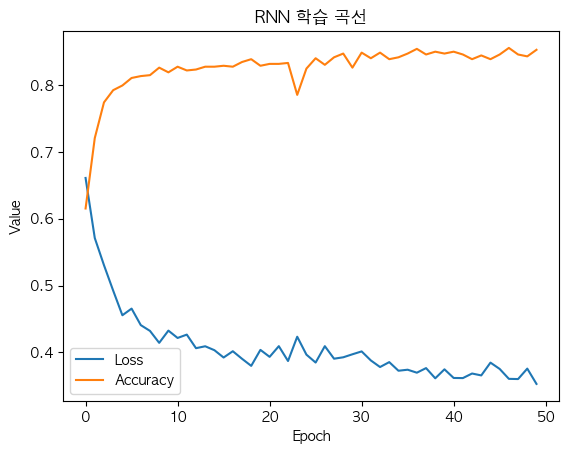

테스트셋 정확도: 0.804
              precision    recall  f1-score   support

           0      0.818     0.857     0.837       105
           1      0.783     0.730     0.755        74

    accuracy                          0.804       179
   macro avg      0.800     0.793     0.796       179
weighted avg      0.803     0.804     0.803       179



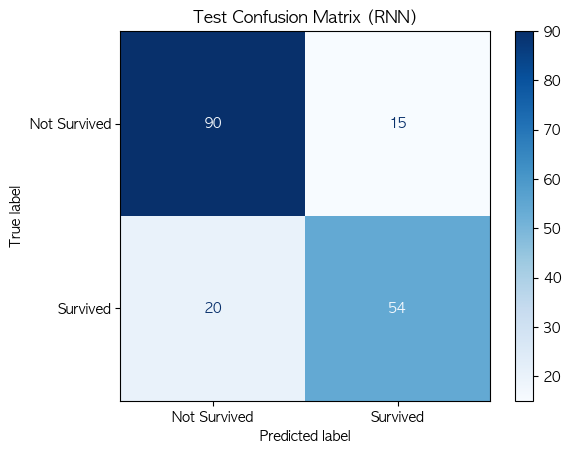

In [12]:

# PyTorch Dataset
class TitanicSeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = TitanicSeqDataset(X_train, y_train)
test_ds = TitanicSeqDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

# 2. RNN 모델 정의 (간단 RNN/LSTM)
class TitanicRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=16, num_layers=1, num_classes=2):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 8),
            nn.ReLU(),
            nn.Linear(8, num_classes)
        )
    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:,-1,:]  # 마지막 시퀀스의 hidden state만 사용
        out = self.fc(out)
        return out

model = TitanicRNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# 3. 학습
losses, accs = [], []
epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (torch.argmax(pred,1)==yb).sum().item()
        total += yb.size(0)
    acc = correct/total
    losses.append(total_loss/len(train_loader))
    accs.append(acc)
    if (epoch+1)%10==0 or epoch==0:
        print(f"Epoch {epoch+1}: Loss={losses[-1]:.4f}, Acc={acc:.3f}")

plt.plot(losses, label="Loss")
plt.plot(accs, label="Accuracy")
plt.title("RNN 학습 곡선")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.show()

# 4. 테스트셋 평가
model.eval()
with torch.no_grad():
    all_pred = []
    all_true = []
    for xb, yb in test_loader:
        pred = model(xb)
        pred_label = torch.argmax(pred,1)
        all_pred.extend(pred_label.cpu().numpy())
        all_true.extend(yb.cpu().numpy())
    all_pred = np.array(all_pred)
    all_true = np.array(all_true)
    test_acc = (all_pred==all_true).mean()
    print(f"테스트셋 정확도: {test_acc:.3f}")

# 5. confusion matrix, classification report
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print(classification_report(all_true, all_pred, digits=3))
cm = confusion_matrix(all_true, all_pred)
ConfusionMatrixDisplay(cm, display_labels=["Not Survived","Survived"]).plot(cmap='Blues')
plt.title("Test Confusion Matrix (RNN)")
plt.show()


In [15]:
# 개선된 LSTM/GRU 모델들 정의
class TitanicLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=2, 
num_classes=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1
else 0)
        self.dropout = nn.Dropout(dropout)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # 마지막 시퀀스의 hidden state
        out = self.batch_norm(out)
        out = self.dropout(out)
        out = self.fc(out)
        return out

class TitanicGRU(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=2, 
num_classes=2, dropout=0.2):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers,
                        batch_first=True, dropout=dropout if num_layers > 1
else 0)
        self.dropout = nn.Dropout(dropout)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]  # 마지막 시퀀스의 hidden state
        out = self.batch_norm(out)
        out = self.dropout(out)
        out = self.fc(out)
        return out

# Early Stopping 클래스
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1

        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False

    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()

# 학습 함수 개선
def train_model(model, train_loader, val_loader, epochs=100, lr=0.001, 
early_stopping=True):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20,
gamma=0.5)
    criterion = nn.CrossEntropyLoss()

    if early_stopping:
        early_stopper = EarlyStopping(patience=10, min_delta=0.001)

    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(epochs):
        # 학습
        model.train()
        total_loss, correct, total = 0, 0, 0
        for xb, yb in train_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  #  gradient clipping
            optimizer.step()

            total_loss += loss.item()
            correct += (torch.argmax(pred, 1) == yb).sum().item()
            total += yb.size(0)

        train_acc = correct / total
        train_losses.append(total_loss / len(train_loader))
        train_accs.append(train_acc)

        # 검증
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                pred = model(xb)
                loss = criterion(pred, yb)
                val_loss += loss.item()
                val_correct += (torch.argmax(pred, 1) == yb).sum().item()
                val_total += yb.size(0)

        val_acc = val_correct / val_total
        val_losses.append(val_loss / len(val_loader))
        val_accs.append(val_acc)

        scheduler.step()

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Train Acc={train_acc:.3f}, "
                    f"Val Loss={val_losses[-1]:.4f}, Val Acc={val_acc:.3f}")

        # Early stopping
        if early_stopping and early_stopper(val_losses[-1], model):
            print(f"Early stopping at epoch {epoch+1}")
            break

    return train_losses, train_accs, val_losses, val_accs

# 검증용 데이터 분할
from sklearn.model_selection import train_test_split
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

train_ds_split = TitanicSeqDataset(X_train_split, y_train_split)
val_ds_split = TitanicSeqDataset(X_val_split, y_val_split)

train_loader_split = DataLoader(train_ds_split, batch_size=32, shuffle=True)
val_loader_split = DataLoader(val_ds_split, batch_size=32, shuffle=False)

print(f"학습 데이터: {len(train_ds_split)}, 검증 데이터: {len(val_ds_split)}, 테스트 데이터: {len(test_ds)}")

학습 데이터: 569, 검증 데이터: 143, 테스트 데이터: 179


1. 원본 RNN 모델 성능
RNN - Accuracy: 0.8324, Precision: 0.8438, Recall: 0.7297, F1: 0.7826

2. LSTM 모델 학습 및 평가
Epoch 1: Train Loss=0.6961, Train Acc=0.543, Val Loss=0.6921, Val Acc=0.622
Epoch 10: Train Loss=0.5431, Train Acc=0.738, Val Loss=0.4954, Val Acc=0.762
Epoch 20: Train Loss=0.5351, Train Acc=0.759, Val Loss=0.5009, Val Acc=0.748
Epoch 30: Train Loss=0.5069, Train Acc=0.779, Val Loss=0.4708, Val Acc=0.762
Epoch 40: Train Loss=0.4775, Train Acc=0.796, Val Loss=0.4544, Val Acc=0.762
Epoch 50: Train Loss=0.4791, Train Acc=0.796, Val Loss=0.4413, Val Acc=0.797
Epoch 60: Train Loss=0.4871, Train Acc=0.773, Val Loss=0.4346, Val Acc=0.783
Epoch 70: Train Loss=0.4892, Train Acc=0.793, Val Loss=0.4278, Val Acc=0.783
Epoch 80: Train Loss=0.4699, Train Acc=0.789, Val Loss=0.4234, Val Acc=0.797
Early stopping at epoch 87
LSTM - Accuracy: 0.8603, Precision: 0.9153, Recall: 0.7297, F1: 0.8120
LSTM 학습 시간: 3.48초

3. GRU 모델 학습 및 평가
Epoch 1: Train Loss=0.6766, Train Acc=0.606, Val Loss=0.6930, Val A

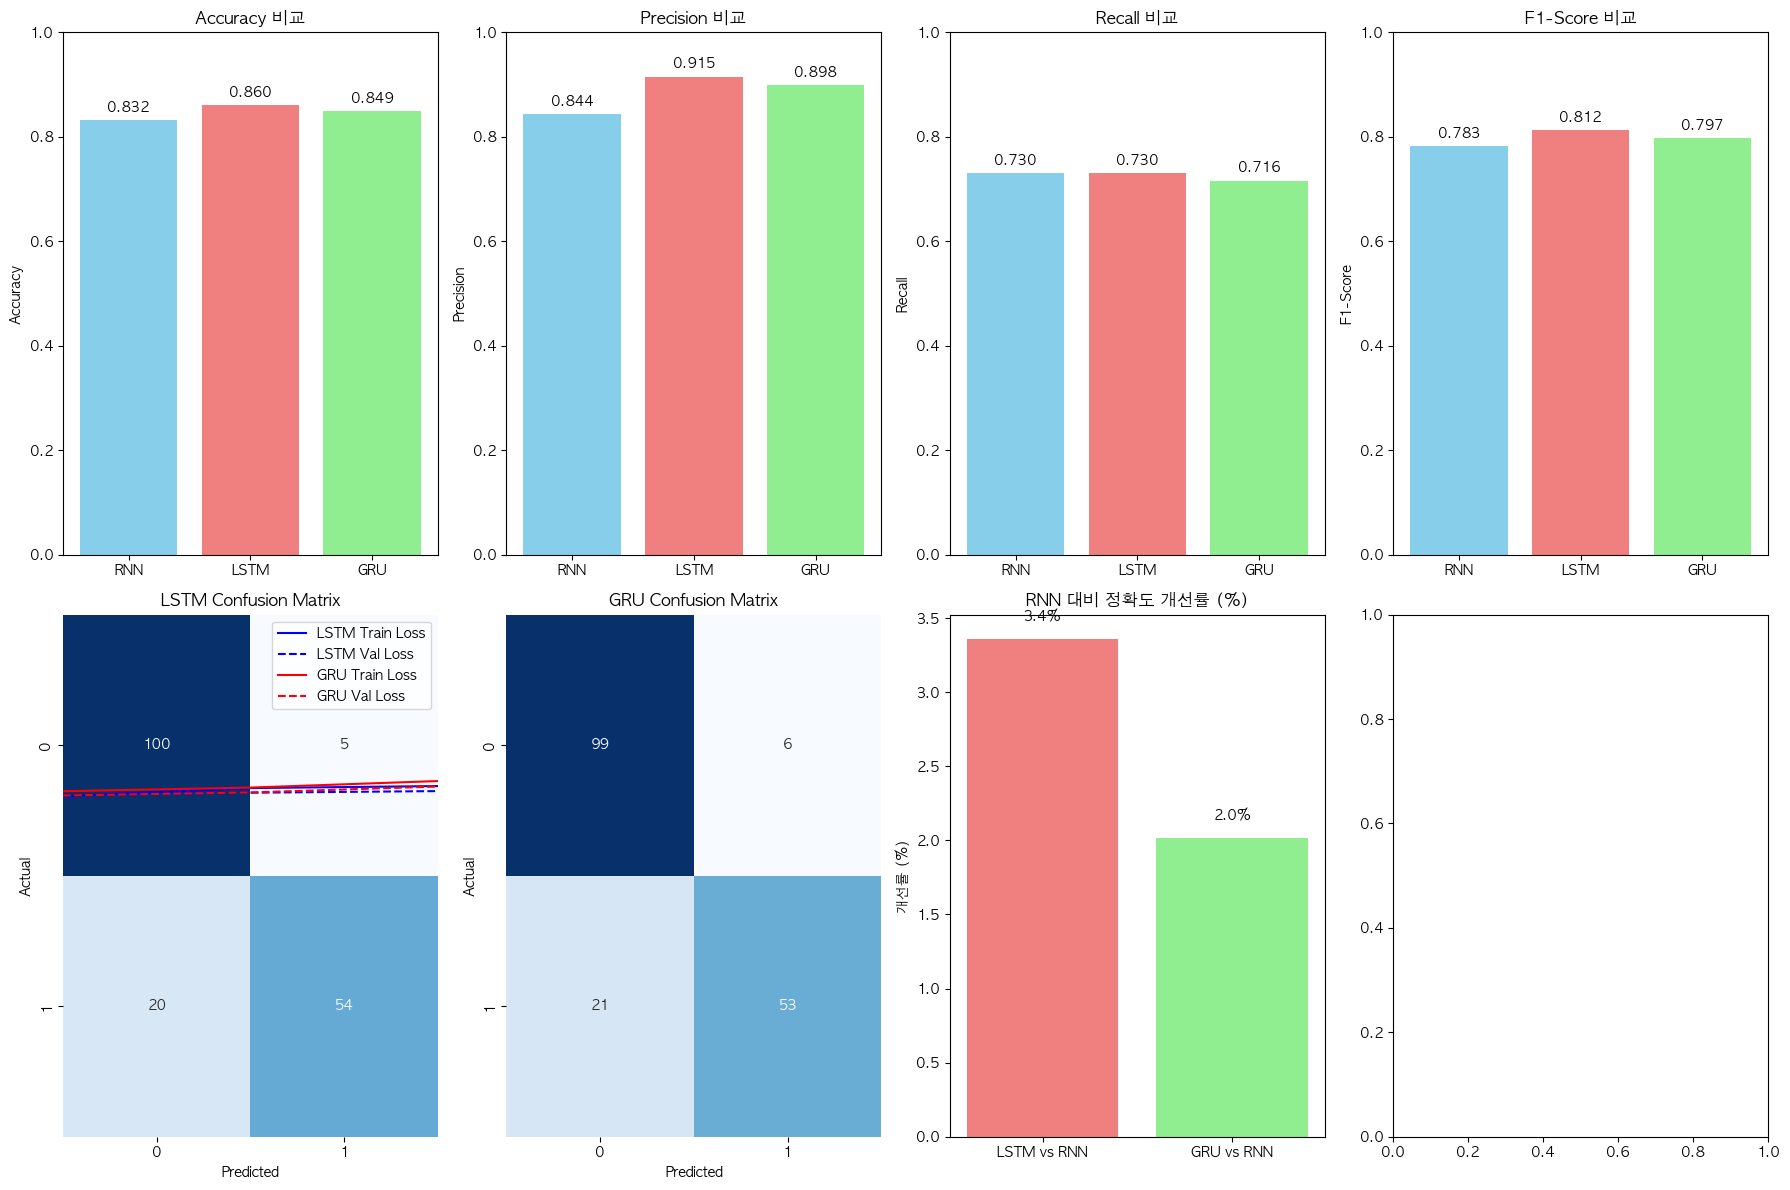


최고 성능 모델: LSTM
F1-Score: 0.8120

LSTM 모델 상세 성능 리포트:
              precision    recall  f1-score   support

Not Survived     0.8333    0.9524    0.8889       105
    Survived     0.9153    0.7297    0.8120        74

    accuracy                         0.8603       179
   macro avg     0.8743    0.8411    0.8505       179
weighted avg     0.8672    0.8603    0.8571       179



In [ ]:
# 모델 성능 비교 실험
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score

def evaluate_model(model, test_loader):
    """모델 평가 함수"""
    model.eval()
    all_pred = []
    all_true = []

    with torch.no_grad():
        for xb, yb in test_loader:
            pred = model(xb)
            pred_label = torch.argmax(pred, 1)
            all_pred.extend(pred_label.cpu().numpy())
            all_true.extend(yb.cpu().numpy())

    all_pred = np.array(all_pred)
    all_true = np.array(all_true)

    accuracy = accuracy_score(all_true, all_pred)
    precision = precision_score(all_true, all_pred)
    recall = recall_score(all_true, all_pred)
    f1 = f1_score(all_true, all_pred)

    return accuracy, precision, recall, f1, all_pred, all_true

# 1. 원본 RNN 모델 성능 (참조용)
print("="*60)
print("1. 원본 RNN 모델 성능")
print("="*60)
original_rnn = TitanicRNN(input_size=1, hidden_size=16, num_layers=1)
optimizer = torch.optim.Adam(original_rnn.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# 간단한 학습 (원본과 동일)
losses, accs = [], []
epochs = 50
for epoch in range(epochs):
    original_rnn.train()
    total_loss, correct, total = 0, 0, 0
    for xb, yb in train_loader:
        pred = original_rnn(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (torch.argmax(pred,1)==yb).sum().item()
        total += yb.size(0)
    acc = correct/total
    losses.append(total_loss/len(train_loader))
    accs.append(acc)

rnn_acc, rnn_prec, rnn_rec, rnn_f1, _, _ = evaluate_model(original_rnn,
test_loader)
print(f"RNN - Accuracy: {rnn_acc:.4f}, Precision: {rnn_prec:.4f}, Recall: {rnn_rec:.4f}, F1: {rnn_f1:.4f}")

# 2. LSTM 모델 학습 및 평가
print("\n" + "="*60)
print("2. LSTM 모델 학습 및 평가")
print("="*60)
lstm_model = TitanicLSTM(input_size=1, hidden_size=32, num_layers=2, dropout=0.2)
start_time = time.time()
lstm_train_losses, lstm_train_accs, lstm_val_losses, lstm_val_accs = train_model(
    lstm_model, train_loader_split, val_loader_split, epochs=100, lr=0.001)
lstm_time = time.time() - start_time

lstm_acc, lstm_prec, lstm_rec, lstm_f1, lstm_pred, lstm_true = evaluate_model(lstm_model, test_loader)
print(f"LSTM - Accuracy: {lstm_acc:.4f}, Precision: {lstm_prec:.4f}, Recall: {lstm_rec:.4f}, F1: {lstm_f1:.4f}")
print(f"LSTM 학습 시간: {lstm_time:.2f}초")

# 3. GRU 모델 학습 및 평가
print("\n" + "="*60)
print("3. GRU 모델 학습 및 평가")
print("="*60)
gru_model = TitanicGRU(input_size=1, hidden_size=32, num_layers=2, dropout=0.2)
start_time = time.time()
gru_train_losses, gru_train_accs, gru_val_losses, gru_val_accs = train_model(
    gru_model, train_loader_split, val_loader_split, epochs=100, lr=0.001)
gru_time = time.time() - start_time

gru_acc, gru_prec, gru_rec, gru_f1, gru_pred, gru_true = evaluate_model(gru_model, test_loader)
print(f"GRU - Accuracy: {gru_acc:.4f}, Precision: {gru_prec:.4f}, Recall: {gru_rec:.4f}, F1: {gru_f1:.4f}")
print(f"GRU 학습 시간: {gru_time:.2f}초")

# 4. 결과 비교 및 시각화
results_dict = {
    'Model': ['RNN', 'LSTM', 'GRU'],
    'Accuracy': [rnn_acc, lstm_acc, gru_acc],
    'Precision': [rnn_prec, lstm_prec, gru_prec],
    'Recall': [rnn_rec, lstm_rec, gru_rec],
    'F1-Score': [rnn_f1, lstm_f1, gru_f1],
    'Training Time (s)': [0, lstm_time, gru_time]  # RNN은 간단 학습이라 0으로 표시
}

results_df = pd.DataFrame(results_dict)
print("\n" + "="*60)
print("4. 모델 성능 비교 결과")
print("="*60)
print(results_df.round(4))

# 시각화
fig, axes = plt.subplots(2, 4, figsize=(18, 12))

# 성능 지표 비교 막대 그래프
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['skyblue', 'lightcoral', 'lightgreen']

for i, metric in enumerate(metrics):
    axes[0, i].bar(results_df['Model'], results_df[metric], color=colors)
    axes[0, i].set_title(f'{metric} 비교')
    axes[0, i].set_ylabel(metric)
    axes[0, i].set_ylim(0, 1)
    for j, v in enumerate(results_df[metric]):
        axes[0, i].text(j, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# 학습 곡선 비교
axes[1, 0].plot(lstm_train_losses, label='LSTM Train Loss', color='blue')
axes[1, 0].plot(lstm_val_losses, label='LSTM Val Loss', color='blue',
linestyle='--')
axes[1, 0].plot(gru_train_losses, label='GRU Train Loss', color='red')
axes[1, 0].plot(gru_val_losses, label='GRU Val Loss', color='red',
linestyle='--')
axes[1, 0].set_title('학습 곡선 (Loss)')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()

# Confusion Matrix 비교
from sklearn.metrics import confusion_matrix
import seaborn as sns

models_data = [
    ('LSTM', lstm_pred, lstm_true),
    ('GRU', gru_pred, gru_true)
]

for i, (name, pred, true) in enumerate(models_data):
    cm = confusion_matrix(true, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                ax=axes[1, i], cbar=False)
    axes[1, i].set_title(f'{name} Confusion Matrix')
    axes[1, i].set_xlabel('Predicted')
    axes[1, i].set_ylabel('Actual')

# 정확도 개선 비교
improvement_lstm = (lstm_acc - rnn_acc) / rnn_acc * 100
improvement_gru = (gru_acc - rnn_acc) / rnn_acc * 100

axes[1, 2].bar(['LSTM vs RNN', 'GRU vs RNN'],
                [improvement_lstm, improvement_gru],
                color=['lightcoral', 'lightgreen'])
axes[1, 2].set_title('RNN 대비 정확도 개선률 (%)')
axes[1, 2].set_ylabel('개선률 (%)')
for i, v in enumerate([improvement_lstm, improvement_gru]):
    axes[1, 2].text(i, v + 0.1, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 최고 성능 모델 선택
best_model_idx = np.argmax([lstm_f1, gru_f1])
best_model_name = ['LSTM', 'GRU'][best_model_idx]
best_model = [lstm_model, gru_model][best_model_idx]

print(f"\n최고 성능 모델: {best_model_name}")
print(f"F1-Score: {max(lstm_f1, gru_f1):.4f}")

# 최종 분류 리포트
print(f"\n{best_model_name} 모델 상세 성능 리포트:")
from sklearn.metrics import classification_report
best_pred = lstm_pred if best_model_name == 'LSTM' else gru_pred
print(classification_report(lstm_true, best_pred, target_names=['Not Survived',
'Survived'], digits=4))
